In [3]:
import torch
import torch_geometric
import torch_geometric.transforms as T
from glob import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cftime
import pickle

In [15]:
class ssp_data():
    def __init__(self, n=39) -> None:
        self.n = n
        self.init_edge_list(n)
        self.y_file = 'data\\tas_scenario_245\\tas_mon_mod_ssp245_192_000.nc'
        self.x_file_list = [item for item in glob('data\\tas_scenario_245\\tas_mon_mod_ssp245_192_*.nc') if item not in [self.y_file]][0 : self.n]
        self.create_df()
        self.test_train_split()
       
        # self.split_data()
        # self.mini_graphs()

    def init_edge_list(self, n):
        self.edge_index = []
        for i in range(n):
            for j in range(n):
                if i != j:
                    self.edge_index.append([i, j])
        self.edge_index = torch.tensor(self.edge_index, dtype=torch.long)

    def create_df(self):
        self.x = pd.DataFrame()
        i = 1
        for filename in self.x_file_list:
            print('Processing', filename)
            if self.x.empty:
                self.x = self.create_vector(filename).reset_index(drop=True)
            else:
                assert len(self.x) == len(w:= self.create_vector(filename)['tas'])
                self.x[f'tas_{i}'] = w.reset_index(drop=True)
                # self.x = self.x.merge(self.create_vector(filename), how='inner', on=['time', 'lat', 'lon'], suffixes=(None, f'_{i}'))
            
            i += 1
        
        self.y = self.create_vector(self.y_file)['tas'].reset_index(drop=True)

    def create_vector(self, filename):
        data = xr.open_dataset(filename)
        try:
            datetimeindex = data.indexes['time'].to_datetimeindex()
            data['time'] = datetimeindex
        except AttributeError:
            pass

        df = data.to_dataframe().reset_index()
        # df = df.query('lat == -43.125 & lat == 288.750')
        df = df.query('lat >= -44 & lat <= -12 & lon >= 288 & lon <= 336')
        ret = df.loc[(df['time'].dt.year > 1960) & (df['time'].dt.year < 1980), ['time', 'lat', 'lon', 'tas']]

        return ret
    
    def test_train_split(self, p=74100):
        df = self.x.drop(columns=['time', 'lat', 'lon'], axis=1)
        self.x_train = df[0:p]
        self.x_test = df[p:]
        self.y_train = df[0:p]
        self.y_test = df[p:]

        self.x_train = self.create_tensors(self.x_train)
        self.y_train = self.create_tensors(self.y_train)
        self.train_data = torch_geometric.data.Data(x=self.x_train, edge_index=self.edge_index.t().contiguous(), y=self.y_train)

        self.x_test = self.create_tensors(self.x_test)
        self.y_test = self.create_tensors(self.y_test)
        self.test_data = torch_geometric.data.Data(x=self.x_test, edge_index=self.edge_index.t().contiguous(), y=self.y_test)

    
    def get_device(self):
        if torch.cuda.is_available():
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu') # don't have GPU 
        return device

    def create_tensors(self, df):
        device = self.get_device()
        return torch.from_numpy(df.values).transpose(0, 1).float().to(device)
    
    def to_pickle(self, name='data_pickle'):
        file = open(name, 'wb')
        pickle.dump(self, file)
        file.close()
    
    # def mini_graphs(self):
    #     df = self.x
    #     df['x_tensor'] = df.apply(lambda row: torch.tensor(row.values.flatten()), axis=1)
    #     df['y'] = self.y
    #     df['y_tensor'] = df['y'].apply(lambda y: torch.tensor(y))
    #     df['data_obj'] = df.apply(lambda row: torch_geometric.data.Data(x=df['x_tensor'], edge_index=self.edge_index.t().contiguous(), y=df['y_tensor']), axis=1)
    #     self.batch_graphs = df['data_obj']
    
    # def split_data(self):
    #     transform = T.Compose([T.RandomNodeSplit(num_test=1000, num_val=1000)])
    #     self.data = transform(self.data) 


In [16]:
ssp_obj = ssp_data(n=8)

Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_001.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_002.nc
Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_003.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_3948\799398034.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_004.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_3948\799398034.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_005.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_3948\799398034.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_006.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_3948\799398034.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_007.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_3948\799398034.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


Processing data\tas_scenario_245\tas_mon_mod_ssp245_192_008.nc


C:\Users\jqcla\AppData\Local\Temp\ipykernel_3948\799398034.py:40: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = data.indexes['time'].to_datetimeindex()


In [17]:
ssp_obj.x

,time,lat,lon,tas,tas_2,tas_3,tas_4,tas_5,tas_6,tas_7,tas_8
0,1961-01-16 12:00:00,-43.125,288.750,286.400269,280.862762,286.771332,285.407745,283.856293,284.691101,284.222473,284.567688
1,1961-02-15 00:00:00,-43.125,288.750,285.905518,281.284271,281.414459,284.798828,283.674713,284.747620,284.870758,285.316010
2,1961-03-16 12:00:00,-43.125,288.750,284.728638,283.605560,281.929413,282.059021,281.492584,282.372467,282.833374,285.541168
3,1961-04-16 00:00:00,-43.125,288.750,280.983887,276.310425,279.923767,279.065002,278.729950,278.684601,278.864471,286.656097
4,1961-05-16 12:00:00,-43.125,288.750,279.186432,272.765076,278.642639,275.679047,275.733490,275.873016,275.867615,287.312958
...,...,...,...,...,...,...,...,...,...,...,...
148195,1979-08-16 12:00:00,-13.125,335.625,294.739410,295.901398,297.703033,296.290222,296.006287,296.114349,296.208649,296.394745
148196,1979-09-16 00:00:00,-13.125,335.625,294.692566,295.707916,297.600006,296.493225,295.870270,295.974457,296.031311,296.582794
148197,1979-10-16 12:00:00,-13.125,335.625,295.054901,296.138306,297.874847,296.958801,296.478088,296.565735,296.519348,296.831482
148198,1979-11-16 00:00:00,-13.125,335.625,295.820404,297.221680,298.484406,297.945587,297.443146,297.509857,297.399323,297.165375


In [19]:
ssp_obj.train_data.x

tensor([[286.4003, 285.9055, 284.7286,  ..., 291.4703, 293.1847, 294.5545],
        [280.8628, 281.2843, 283.6056,  ..., 290.8286, 292.2475, 294.4779],
        [286.7713, 281.4145, 281.9294,  ..., 292.8046, 294.0486, 295.0403],
        ...,
        [284.6911, 284.7476, 282.3725,  ..., 291.9288, 293.4259, 295.5172],
        [284.2225, 284.8708, 282.8334,  ..., 292.2746, 293.7310, 295.2097],
        [284.5677, 285.3160, 285.5412,  ..., 295.6305, 296.0980, 296.6026]])

In [20]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.edge_weight = torch.nn.Parameter(torch.ones(ssp_obj.train_data.num_edges))
        self.conv1 = GCNConv(ssp_obj.train_data.num_node_features, 16)
        self.conv2 = GCNConv(16, ssp_obj.train_data.num_node_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # print(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))
        x = self.conv2(x, edge_index, torch.minimum(self.edge_weight.abs(),torch.ones(data.num_edges)))

        return x


In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
train_data = ssp_obj.train_data.to(device)
test_data = ssp_obj.test_data.to(device)
train_loss_l = []
test_loss_l = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.05, weight_decay=5e-4)

model.train()
for epoch in range(5000):
    optimizer.zero_grad()
    out = model(train_data)
    train_loss = F.mse_loss(out, train_data.y)
    train_loss_l.append(train_loss.item())

    test_out = model(test_data)
    test_loss = F.mse_loss(test_out, test_data.y)
    test_loss_l.append(test_loss.item())

    print(epoch, train_loss, test_loss)
    train_loss.backward()
    optimizer.step()

0 tensor(83742.5156, grad_fn=<MseLossBackward0>) tensor(86725.7422, grad_fn=<MseLossBackward0>)
1 tensor(3.0630e+10, grad_fn=<MseLossBackward0>) tensor(4.7716e+10, grad_fn=<MseLossBackward0>)
2 tensor(1.0613e+10, grad_fn=<MseLossBackward0>) tensor(8.5777e+09, grad_fn=<MseLossBackward0>)
3 tensor(2.0747e+08, grad_fn=<MseLossBackward0>) tensor(76233920., grad_fn=<MseLossBackward0>)
4 tensor(5.0041e+08, grad_fn=<MseLossBackward0>) tensor(5.4339e+08, grad_fn=<MseLossBackward0>)
5 tensor(1233245.7500, grad_fn=<MseLossBackward0>) tensor(776186.1875, grad_fn=<MseLossBackward0>)
6 tensor(83748.9141, grad_fn=<MseLossBackward0>) tensor(86736.5703, grad_fn=<MseLossBackward0>)
7 tensor(83753.0781, grad_fn=<MseLossBackward0>) tensor(86740.8125, grad_fn=<MseLossBackward0>)
8 tensor(83756.7266, grad_fn=<MseLossBackward0>) tensor(86744.5156, grad_fn=<MseLossBackward0>)
9 tensor(83759.9453, grad_fn=<MseLossBackward0>) tensor(86747.7969, grad_fn=<MseLossBackward0>)
10 tensor(83762.7969, grad_fn=<MseLoss

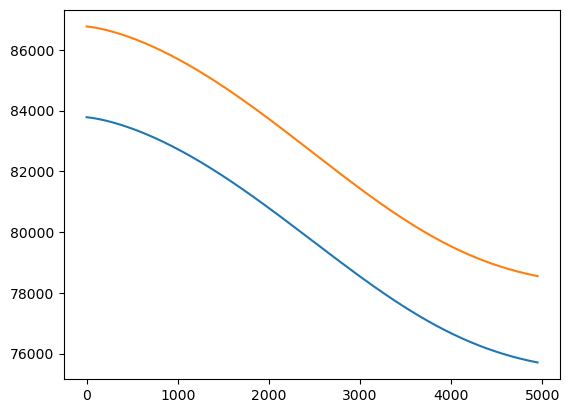

In [22]:
plt.plot(train_loss_l[50:], label='train')
plt.plot(test_loss_l[50:], label='test')

In [35]:
len(model.edge_weight)

380

In [108]:
model.eval()
out = model(data)
mse = F.mse_loss(out, data.y)
print(f'MSE: {mse:.4f}')

MSE: 84940.0234


C:\Users\jqcla\AppData\Local\Temp\ipykernel_17512\121057100.py:3: UserWarning: Using a target size (torch.Size([70200])) that is different to the input size (torch.Size([8, 70200])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(out, data.y)
